# Train Models, Tune Hyper Parameters and Compare Performance

FIXME: After running this with the new settings, adapt the markdown cells to
report the correct new values.

In this notebook, I will train (or rather fine-tune) multiple models,
tune their hyperparameters, evaluate and compare their performance,
select a final model and evaluate its performance on the test set.

## ResNet18

I will start with testing a ResNet18.
It is relative lightweight, but still powerful, and suitable for training
locally on my machine.
If that one doesn't do the job, I will have to try larger models.

Another reason to start with ResNet18 is that the
data set just contains about 6000 images in total, which is not that large.
A smaller model may be more suitable for transfer learning here, as it is less
prone to overfit and may handle the rather small number of images better.

## Preparations

In [1]:
# dependencies
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image

from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from statistics import mean
from statistics import stdev

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models


In [2]:
# paths
PATH_DATA_PROCESSED = Path("../data/processed")
PATH_DATA_TRAIN = PATH_DATA_PROCESSED / "train"
PATH_DATA_TEST = PATH_DATA_PROCESSED / "test"
PATH_MODELS = Path("../models")

In [3]:
# set device based on available hardware
device = (
    "mps" if torch.backends.mps.is_available() # for Apple Silicon chips
    else "cuda" if torch.cuda.is_available() # for NVIDIA GPUs
    else "cpu" # for CPU
)
print(f"using device: {device}")

using device: mps


### Apply Minimal Data Transformations

Before training, a minimal data transformation pipeline has to be applied to
the images.
It converts the images to tensors and normalizes their pixel values.
Here, the pixel values are normalized according to the ImageNet mean values.
This is done, because the ResNet18 was pre-trained on ImageNet.
Resizing to 224 times 224 pixels was done previously during data preparation.
That's all that's done to the data here.
Further transformations such as geometric transformations, color modifications
and random transformations are not applied.
These transformations often help improving model robustness and generalization
and prevent overfitting.
They can be used in case the models perform poorly, but here, I'm not expecting
that to be the case.

Then, the training data has to be split into a training and a validation set.
Using k-fold cross validation would increase the computational cost and training
time too much to train the models locally on my laptop in a reasonable time.
Therefore, a single train / validation split is used.
The test set will only be used once in the very end to evaluate the final model
on unseen data.

In [4]:
# define image transformations
transform = transforms.Compose([
    # convert PIL images to PyTorch tensor and scale pixel value range to 0-1
    transforms.ToTensor(),
    # normalize image image according to ImageNet statistics
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

def custom_loader(path):
    """Custom image loader that forces image reading in RGB mode."""
    try:
        # force RGB mode during initial open
        img = Image.open(path).convert("RGB")
        return img
    except Exception as e:
        print(f"Error loading image {path}: {str(e)}")
        # return a default image as fallback with mean values matching ImageNet
        return Image.new("RGB", (224, 224), (128, 128, 128))

# recreate datasets with new loader and transforms
full_train_dataset = datasets.ImageFolder(
    PATH_DATA_TRAIN,
    loader=custom_loader,
    transform=transform
)
test_dataset = datasets.ImageFolder(
    PATH_DATA_TEST,
    loader=custom_loader,
    transform=transform
)

# split training data into train (80%) and validation (20%)
val_size = int(0.2 * len(full_train_dataset))
train_size = len(full_train_dataset) - val_size
# set random seed for reproducibility
random_seed = 69
torch.manual_seed(random_seed)
train_dataset, val_dataset = random_split(
    full_train_dataset, [train_size, val_size]
)

# create dataloaders
# batch size of 32 often leads to good generalization and fits my local memory
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# print some basic info
print(f"number of training images: {len(train_dataset)}")
print(f"number of validation images: {len(val_dataset)}")
print(f"number of test images: {len(test_dataset)}")
print(f"classes: {test_dataset.classes}")

number of training images: 3784
number of validation images: 946
number of test images: 1182
classes: ['chihuahua', 'muffin']


## Unmodified Pre-Trained ResNet18

Before fine-tuning and optimizing models using transfer learning,
it would be interesting to see the prediction of an unchanged model.

Resnet18, by default, has 1000 instead of two classes, so it will not directly
output either "muffin" or "chihuahua".
Instead, it will output a probability for each of the 1000 classes and finally
pick the class with the highest probability.
Among these 1000 classes are many more things like more general classes like
"dog" and probably "cake" as well as other animals and objects.

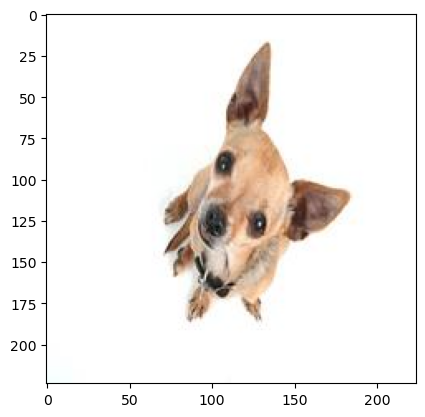


Top 5 predictions:
Chihuahua: 78.81%
toy terrier: 14.70%
miniature pinscher: 1.13%
muzzle: 0.76%
Mexican hairless: 0.28%


In [5]:
# load fresh pre-trained ResNet18 without modifications
model_raw = models.resnet18(weights="IMAGENET1K_V1")
model_raw = model_raw.to(device)
model_raw.eval()  # set to evaluation mode

# get ImageNet class labels
IMAGENET_CLASSES_URL = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"

# get ImageNet class mappings
response = requests.get(IMAGENET_CLASSES_URL)
imagenet_classes = [line.strip() for line in response.text.splitlines() if line.strip()]

def predict_image_raw(model, image_path, device):
    """Show and predict a single image using raw ResNet18."""
    
    # set model to evaluation mode
    model.eval()
    
    # load and display image
    img = custom_loader(image_path)
    plt.imshow(img)
    plt.show()

    # preprocess the image
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    # get prediction
    with torch.no_grad():
        output = model(img_tensor)
        prob = torch.nn.functional.softmax(output, dim=1)
        # get top 5 predictions
        top5_prob, top5_idx = torch.topk(prob, 5)
    
    # get class names and probabilities
    predictions = []
    for i in range(5):
        class_name = imagenet_classes[top5_idx[0][i]]
        probability = top5_prob[0][i].item()
        predictions.append((class_name, probability))
    
    return predictions

# use the function to predict one image
test_image_path = PATH_DATA_PROCESSED / "test" / "chihuahua" / "img_1_144.jpg"
predictions = predict_image_raw(model_raw, test_image_path, device)
print("\nTop 5 predictions:")
for class_name, confidence in predictions:
    print(f"{class_name}: {confidence:.2%}")

Cool! It did well and even predicted it to be a chihuahua! But that one's an
easy picture and it also still outputs the probabilities for the other classes.
There will certainly be cases in which it doesn't predict either muffin or
chihuahua, but instead something else, so it has to be adapted to use just two
classes.

## Establishing a Baseline - Default ResNet18

Before tuning hyper parameters, I will fine-tune this ResNet18 without any
modification except for the final layer in which there will be only two
classes - muffin and chihuahua.
All other values are kept at their default values.
This includes the learning rate used for the Adam optimizer, which is 0.001.
Its performance will then serve as the baseline in this comparison.
Subsequently, variations of this model will be trained.
For example, I will introduce dropout and extra layers.
These modified versions' performance will be compared to the baseline as well as
to another, and finally the best performing model will be selected.


### Set Up Transfer Learning Pipeline using ResNet18 and Fine-Tune

In [6]:
# load pre-trained ResNet18 to an object
# this model was pre-trained on ImageNet on 1000 classes
model_baseline = models.resnet18(weights="IMAGENET1K_V1")

# freeze all layers
# this preserves the feature extraction capabilities learned from ImageNet
for param in model_baseline.parameters():
    param.requires_grad = False

# modify the final layer for binary classification
# this replaces the final fully connected layer (fc) (hence: model.*fc*)
# the original fc had 1000 output probabilities (bc. trained on 1000 classes)
# here, there's just two classes (muffins and chihuahuas) -> replace
# get number of input features to fc
num_features = model_baseline.fc.in_features
# replace with new layer matching input features and output classes
model_baseline.fc = nn.Linear(num_features, 2) # 2 classes: muffin and chihuahua

# move model to GPU
model_baseline = model_baseline.to(device)

In [7]:
# define loss function and optimizer
# Cross Entropy Loss is well suited and widely used for classification problems
criterion = nn.CrossEntropyLoss()

# only optimize the parameters of the final layer since others are frozen
# start with a static learning rate (lr) of 0.001
optimizer = optim.Adam(model_baseline.fc.parameters(), lr=0.001)

In [8]:
def train_one_epoch(model, train_loader, criterion, optimizer, device): 
    """Train the model for one epoch."""
    
    # set model to training mode
    model.train()
    # initialize running loss and accuracy
    running_loss = 0.0 # accumulator for loss across batches
    correct = 0 # accumulator for correct predictions across batches
    total = 0 # accumulator for total predictions across batches

    # iterate over the batches of training data
    for inputs, labels in train_loader:
        # move each batch of data to device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero / reset the parameter gradients from previous bachward passes
        optimizer.zero_grad()
        
        # forward pass
        # get model predictions
        outputs = model(inputs)
        # compute loss
        loss = criterion(outputs, labels)
        
        # backward pass
        # compute gradients
        loss.backward()
        # update model parameters / weights
        optimizer.step()
        
        # accumulate loss and statistics
        # accumulate batch loss
        running_loss += loss.item()
        # get predicted class
        _, predicted = outputs.max(1)
        # accumulate total predictions
        total += labels.size(0)
        # accumulate correct predictions
        correct += predicted.eq(labels).sum().item()
    
    # calculate epoch statistics
    # average loss over all batches
    epoch_loss = running_loss / len(train_loader)
    # calculate accuracy
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

In [9]:
def validate(model, val_loader, criterion, device):
    """Validate the model."""
    
    # set model to evaluation mode
    model.eval()
    # initialize running loss and accuracy
    val_loss = 0.0
    all_labels = []
    all_preds = []
    all_probs = []
    
    # iterate over the batches of validation data
    with torch.no_grad():
        
        # iterate over the batches of validation data
        for inputs, labels in val_loader:
            
            # move each batch of data to device
            inputs, labels = inputs.to(device), labels.to(device)
            # get model predictions
            outputs = model(inputs)
            # compute loss
            loss = criterion(outputs, labels)
            
            # accumulate loss
            val_loss += loss.item()
            
            # get predictions and probabilities
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            
            # collect all predictions and labels
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
            
            
    # calculate metrics
    val_loss = val_loss / len(val_loader)
    val_acc = 100. * accuracy_score(all_labels, all_preds)
    val_roc_auc = roc_auc_score(all_labels, all_probs)
    val_f1 = f1_score(all_labels, all_preds)
    
    return {
        'val_loss': val_loss,
        'val_acc': val_acc,
        'val_roc_auc': val_roc_auc,
        'val_f1': val_f1
    }

In [10]:
def evaluate_model(model_name, validation_results, include_model_info=False):
    """
    Summarize model performance across validation results.
    
    Args:
        model_name (str): name of the model for identification
        history (dict): dictionary containing training history
            each dictionary should have 'train_loss', 'train_acc', 'val_metrics'
    
    Returns:
        dict: summary statistics for each metric (mean ± std)
    """
    # collect metrics
    metrics = {
        'val_loss': [],
        'val_acc': [],
        'val_roc_auc': [],
        'val_f1': []
    }
    
    # collect metrics from all validation results
    for result in validation_results:
        metrics['val_loss'].append(result['val_loss'])
        metrics['val_acc'].append(result['val_acc'])
        metrics['val_roc_auc'].append(result['val_roc_auc'])
        metrics['val_f1'].append(result['val_f1'])
    
    # initialize summary dictionary
    summary = {}
    
    # include info about model if desired
    if include_model_info:
        summary['model'] = model_name
        
    # compute mean and standard deviation and add to summary
    summary['val_loss'] = f"{mean(metrics['val_loss']):.4f} ± {stdev(metrics['val_loss']):.4f}"
    summary['val_acc'] = f"{mean(metrics['val_acc']):.2f}% ± {stdev(metrics['val_acc']):.2f}%"
    summary['val_roc_auc'] = f"{mean(metrics['val_roc_auc']):.4f} ± {stdev(metrics['val_roc_auc']):.4f}"
    summary['val_f1'] = f"{mean(metrics['val_f1']):.4f} ± {stdev(metrics['val_f1']):.4f}"
    
    return summary

In [11]:
# make class for early stopping
class EarlyStopping:
    """Early stopping to prevent overfitting"""
    
    def __init__(self,
        patience=7,
        min_delta=0,
        path='checkpoint.pt'
    ):
        """
        Args:
            patience (int): How many epochs to wait before stopping when loss is
            not improving
            min_delta (float): Minimum change in the monitored quantity to 
            qualify as an improvement
            path (str): Path for the checkpoint to be saved to
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path
        self.best_model = None
    
    def __call__(self, val_loss, model):
        # first epoch
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        # improvement
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0
        # no improvement
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
    
    def save_checkpoint(self, model):
        """Saves model when validation loss decreases."""
        torch.save(model.state_dict(), self.path)
        self.best_model = model.state_dict()

In [12]:
# number of epochs to train for
# 50 epochs is commonly used in transfer learning
# smaller number of epoch may be sufficient as well, but
# use a larger number, because early stopping is applied
n_epochs = 50

# initialize early stopping object
    # patience
    # 7 is within range of 5 - 20 commonly used in practice
    # has enough buffer to prevent stopping too early due to temporary plateaus
    # not too large to waste computational resources
    # min_delta
    # 0.001 is commonly used in practice
    # small enough to catch meaninful improvements
early_stopping_baseline = EarlyStopping(
    patience=7,
    min_delta=0.001,
    path=PATH_MODELS / "model_checkpoint_baseline.pt"
)

# initialize dictionary for training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_metrics': []
}

# train and validate for n_epochs
for epoch in range(n_epochs):
    
    # train for one epoch
    train_loss, train_acc = train_one_epoch(
        model_baseline,
        train_loader,
        criterion,
        optimizer,
        device
    )
    
    # validate 
    val_metrics = validate(
        model_baseline,
        val_loader,
        criterion,
        device
    )
    
    # store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_metrics'].append(val_metrics)
    
    print(f"Epoch {epoch+1}/{n_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(
        f"Val Loss: {val_metrics['val_loss']:.4f}, "
        f"Val Acc: {val_metrics['val_acc']:.2f}%"
    )
    print("-" * 50)
    
    # check improvement in val loss for early stopping
    early_stopping_baseline(val_metrics['val_loss'], model_baseline)
    
    # check if early stopping is triggered
    # if there is no improvement for longer than patience, stop training
    if early_stopping_baseline.early_stop:
        print(f"Early stopping triggered at epoch {epoch + 1}")
        # load best model from checkpoint
        model_baseline.load_state_dict(early_stopping_baseline.best_model)
        break

Epoch 1/50:
Train Loss: 0.1597, Train Acc: 94.71%
Val Loss: 0.0466, Val Acc: 99.37%
--------------------------------------------------
Epoch 2/50:
Train Loss: 0.0603, Train Acc: 98.10%
Val Loss: 0.0313, Val Acc: 99.58%
--------------------------------------------------
Epoch 3/50:
Train Loss: 0.0469, Train Acc: 98.55%
Val Loss: 0.0254, Val Acc: 99.37%
--------------------------------------------------
Epoch 4/50:
Train Loss: 0.0387, Train Acc: 98.78%
Val Loss: 0.0217, Val Acc: 99.58%
--------------------------------------------------
Epoch 5/50:
Train Loss: 0.0391, Train Acc: 98.71%
Val Loss: 0.0203, Val Acc: 99.26%
--------------------------------------------------
Epoch 6/50:
Train Loss: 0.0403, Train Acc: 98.60%
Val Loss: 0.0180, Val Acc: 99.26%
--------------------------------------------------
Epoch 7/50:
Train Loss: 0.0327, Train Acc: 98.84%
Val Loss: 0.0194, Val Acc: 99.26%
--------------------------------------------------
Epoch 8/50:
Train Loss: 0.0332, Train Acc: 98.86%
Val L

While the model was trained, early stopping was triggered.
Patience was set to 7, so the model had its best performance 7 epochs before
stopping, and was last loaded to the checkpoint then.
After early stopping, the model was loaded 
to the object `model_baseline` from the checkpoint.

### Validation Metrics

To get an idea of the model's performance, let's have a look at some metrics
from the validation set which were computed during training.
The test set will not be used yet, but only once in the very end.

In [13]:
# get evaluation report
# these are the averages of the batches
metrics_val_baseline =evaluate_model(
    model_baseline,
    history["val_metrics"],
    include_model_info=False
)

metrics_val_baseline

{'val_loss': '0.0179 ± 0.0083',
 'val_acc': '99.47% ± 0.14%',
 'val_roc_auc': '0.9999 ± 0.0001',
 'val_f1': '0.9941 ± 0.0015'}

Performance on the validation set is already pretty impressive.
It's at 0.9999 ROC AUC and 0.9941 F1 score.
That's near perfect, and there is not much room for improvement.

### Testing Model Inference

We finally have a fine tuned model with just two classes!
Now it is time to check if the model can be used to make a prediction.

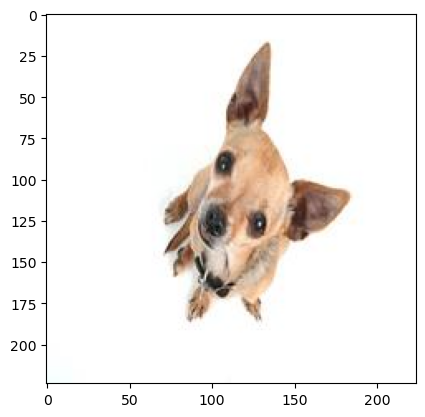

Prediction: chihuahua with 100.00% confidence


In [14]:
def predict_image(model, image_path, device):
    """Show and predict a single image."""
    
    # set model to evaluation mode
    model.eval()
    
    # load and display image
    img = custom_loader(image_path)
    plt.imshow(img)
    plt.show()

    # preprocess the image
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    # get prediction
    with torch.no_grad():
        output = model(img_tensor)
        prob = torch.nn.functional.softmax(output, dim=1)
        pred_idx = output.argmax(dim=1).item()
    
    # get class name and probability
    class_name = train_dataset.dataset.classes[pred_idx]
    probability = prob[0][pred_idx].item()
    
    return class_name, probability

# use the function to predict one image
test_image_path = PATH_DATA_PROCESSED / "test" / "chihuahua" / "img_1_144.jpg"
pred_class, confidence = predict_image(model_baseline, test_image_path, device)
print(f"Prediction: {pred_class} with {confidence:.2%} confidence")

Amazing! It is 100.00% confident about this :D
The model can be used, and made one correct prediction.

## Hyper Parameter Tuning

Now, these hyper parameters will be tuned to potentially improve the model's
performance even further.

  - learning rate
  - dropout
  - hidden layers

Hyper parameter tuning can be done sequentially one after another,
or it can be done using more sophisticated methods, like for example a grid
search across all parameters or Bayesian optimization.
Here, I will do it sequentially, because the other methods may require more
resources and so far the model is performing well, so there may not be the need
for highly sophisticated methods to improve it even more.
It does not allow exploring all specified combinations, but
I doubt this pre-trained model will get stuck in local optima and doing it
sequentially allows me to better understand how each parameter affects the
model.

#### Order of Tuning

Learning rate is typically the most important hyperparameter to tune first,
as it often has the largest impact on the performance of pre-trained models.
Typically, a small learning rate is used to only slightly adjust the pretrained
weights.
If the learning rate is too high, the pretrained weights could be changed too
much and cause the network to forget the pretrained knowledge.

Dropout follows as the second parameter, because the dropout rate strongly
depends on the chosen learning rate.
Dropout helps find the balance between retaining the pretrained knowledge and
adapting to new data.
Newer studies confirm that very high dropout rates are particularly effective
when fine-tuning pre-trained models.

The architecture modifications are adjusted last, because
ResNet18 already has an optimized architecture,
and architectural changes at the end of the network (after global average
pooling) are most effective.
The previous optimization of learning rate and dropout creates a stable basis
for architectural changes.
Here, additional fully connected layers will be added after the dropout layer.

#### 80:20 train:val instead of k-fold Cross Validation

For hyper parameter tuning, k-fold cross validation is a commonly applied
technique.
Here, however, it is not implemented.
Again, the same 80:20 train:val split is used.
Pre-trained models tend to be more stable in their performance and the data set
should still be large enough for reliable validation without k-fold.
The adaptations in the final layer are less sensitive to fold variations,
so k-fold is not strictly necessary.
The small standard deviation in the model's validation accuracy
supports this expectation of a stable performance.
Using K-fold would require training the model k times
(typically 5 or 10), which would further multiply the computational cost.
Since I'm training locally on my laptop, I have less options for
parallelization, this also means a significant increase in training time.
k-fold would be more important if I had used a smaller data set, a custom
architecture, trained a model from scratch
or if there was the need for very high performance or very precise performance
estimates.
### Tune Learning Rate

Learning rate is typically the most important hyper parameter to tune first,
as it has the largest impact on model performance.
I will test three different learning rates using the same model architecture
and training setup as for the baseline:

- 0.0001
- 0.001 (used for the baseline)
- 0.01

0.001 is also used for the baseline, so basically, the baseline will be
compared to the other two learning rates.

In [15]:
def train_with_learning_rate(lr, n_epochs=50):
    """
    Train model with specified learning rate and return validation results.
    """
    
    # initialize model (same as baseline)
    model = models.resnet18(weights="IMAGENET1K_V1")
    
    # freeze all layers
    for param in model.parameters():
        param.requires_grad = False
    
    # modify the final layer for binary classification
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 2)
    
    # move model to GPU
    model = model.to(device)
    
    # initialize with specified learning rate
    optimizer = optim.Adam(model.fc.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # initialize early stopping
    early_stopping = EarlyStopping(
        patience=7,
        min_delta=0.001,
        path=PATH_MODELS / f"model_checkpoint_lr_{lr}.pt"
    )
    
    # initialize history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_metrics': []
    }
    
    # train and validate
    for epoch in range(n_epochs):
        
        train_loss, train_acc = train_one_epoch(
            model,
            train_loader,
            criterion,
            optimizer,
            device
        )
        
        val_metrics = validate(
            model,
            val_loader,
            criterion,
            device
        )
        
        # store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_metrics'].append(val_metrics)
        
        # print epoch information
        print(f"Epoch {epoch+1}/{n_epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(
            f"Val Loss: {val_metrics['val_loss']:.4f}, "
            f"Val Acc: {val_metrics['val_acc']:.2f}%"
        )
        print("-" * 50)
        
        # early stopping check
        early_stopping(val_metrics['val_loss'], model) # returns True or False
        # if early stopping is triggered, break the loop
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            
            # load best model from checkpoint
            model.load_state_dict(early_stopping.best_model)
            break
    
    return history

In [16]:
# test different learning rates
learning_rates = [0.0001, 0.001, 0.01]
results = {}

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    print("-" * 50)
    history = train_with_learning_rate(lr)
    results[lr] = evaluate_model(f"ResNet18_(lr={lr})", history["val_metrics"])
    print("-" * 50)
    print(f"Results for lr={lr}:")
    for key, value in results[lr].items():
        print(f"{key}: {value}")
    print("-" * 50)


Training with learning rate: 0.0001
--------------------------------------------------
Epoch 1/50:
Train Loss: 0.4785, Train Acc: 80.81%
Val Loss: 0.2875, Val Acc: 95.45%
--------------------------------------------------
Epoch 2/50:
Train Loss: 0.2346, Train Acc: 95.80%
Val Loss: 0.1619, Val Acc: 98.41%
--------------------------------------------------
Epoch 3/50:
Train Loss: 0.1620, Train Acc: 97.01%
Val Loss: 0.1109, Val Acc: 99.15%
--------------------------------------------------
Epoch 4/50:
Train Loss: 0.1302, Train Acc: 97.49%
Val Loss: 0.0865, Val Acc: 99.15%
--------------------------------------------------
Epoch 5/50:
Train Loss: 0.1087, Train Acc: 97.83%
Val Loss: 0.0745, Val Acc: 99.26%
--------------------------------------------------
Epoch 6/50:
Train Loss: 0.0929, Train Acc: 97.94%
Val Loss: 0.0629, Val Acc: 99.37%
--------------------------------------------------
Epoch 7/50:
Train Loss: 0.0838, Train Acc: 98.07%
Val Loss: 0.0560, Val Acc: 99.26%
------------------

#### Model Selection

The models will be selected based on best **ROC AUC score**, which is well
suited for binary classification.
It is classification threshold independent,
meaning that it provides one single score for model performance across all
possible classification thresholds.
F1 score is great when you need a balance between precision and recall, but it
still depends on the classification threshold.
F1 score also handles class imbalances well,
but the muffin vs. chihuahua data set is rather balanced 
(~46% muffins, ~54% chihuahuas).

In [17]:
# collect roc auc scores across all learning rates
roc_auc_scores_lr = pd.DataFrame([
    {
        "learning_rate": lr,
        "roc_auc": float(results[lr]["val_roc_auc"].split(" ± ")[0]),
        "std": float(results[lr]["val_roc_auc"].split(" ± ")[1])
    }
    for lr in results
])

roc_auc_scores_lr

,learning_rate,roc_auc,std
0,0.0001,0.9997,0.0008
1,0.0010,0.9999,0.0001
2,0.0100,0.9999,0.0001


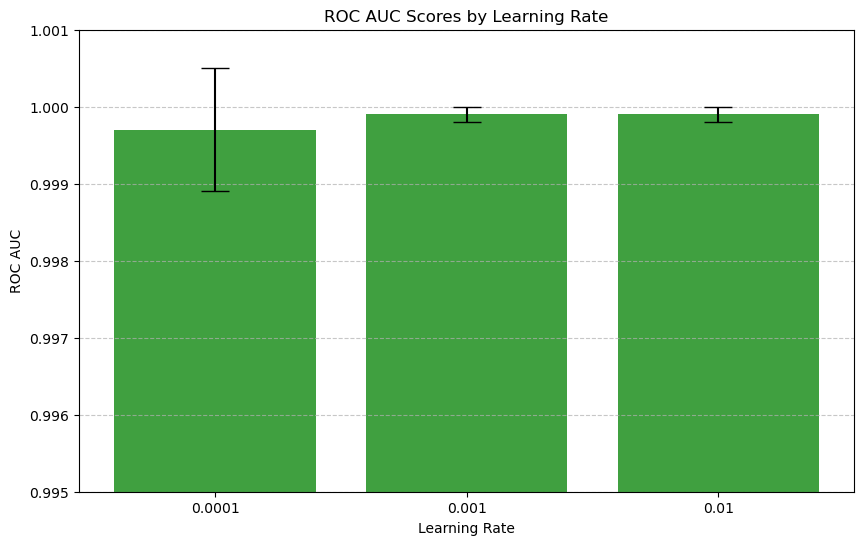

In [18]:
# make bar plot with error bars
plt.figure(figsize=(10, 6))
plt.bar(
    roc_auc_scores_lr["learning_rate"].astype(str),
    roc_auc_scores_lr["roc_auc"],
    yerr=roc_auc_scores_lr["std"],
    capsize=10,
    color="green",
    alpha=0.75
)

# customize plot
plt.title("ROC AUC Scores by Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("ROC AUC")

# adjust y-axis to better show the differences
plt.ylim(0.995, 1.001)

# add horizontal grid lines for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

First of all, it can be seen that there is a mathematical impossibility here.
The mean ROC AUC at a learning rate of 0.0001 is 0.9994, and the standard
deviation is 0.0008.
0.9994 + 0.0008 = 1.0002 > 1.0.
This likely happened because the values come from mean ± standard deviation
calculations across validation results.
While the individual ROC AUC scores were all ≤ 1.0, the standard deviation
calculation doesn't account for this bound.
It is, however, not much of an issue right here, and it can be ignored for now.

The model's performances are very similar and close to optimal regarding ROC AUC
at all learning rates.
The differences are minimal.
Still, at a learning rate of 0,001, the model's ROC AUC becomes maximal 
at 0.9997 with standard deviation of 0.0001
indicates a stable performance estimate.

The unmodified model trained first also a learning rate of 0.001.
It had a ROC AUC of 0.9996 with a standard deviation of 0.0000,
so both values differs by just 0.0001, which is a minimal deviation and can
likely be attributed to to the stochastic elements of training neural networks.
This shows that the model's performance is prettystable.

Based on this test, here, the learning rate will continue to be set to 0.001.
So actually nothing really changed about the model after tuning this hyper
parameter.
Still, this result could have been different, and any other learning rate could
have come out on top, so it's good to have done the test.

### Add Dropout Layers

Now, the dropout hyper parameter will be tuned.
Four dropout probabilities will be used here: 0.2, 0.3, 0.4 and 0.5.
This range of probabilities is commonly found in practice.
Dropout was found to be effective in the context of pre-trained models.

In [19]:
# make class for dropout
class ResNet18_dropout(nn.Module):
    """ResNet18 with dropout layer."""
    def __init__(self, dropout_rate):
        super(ResNet18_dropout, self).__init__()
        self.model = models.resnet18(weights="IMAGENET1K_V1")
        num_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(p=dropout_rate),  # add dropout layer
            nn.Linear(num_features, 2)  # 2 classes: muffin and chihuahua
        )

    def forward(self, x):
        return self.model(x)

In [20]:
# test different dropout rates
dropout_rates = [0.2, 0.3, 0.4, 0.5] # common range for dropout probabilities
lr = 0.001 # best learning rate from previous tuning
results_dropout = {}

def train_with_dropout(dropout_rate, lr=0.001, n_epochs=50):
    """
    Train model with specified dropout rate and return validation results.
    """
    
    # initialize model with dropout and send to device
    model = ResNet18_dropout(dropout_rate=dropout_rate).to(device)
    
    # initialize optimizer and criterion
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # initialize early stopping
    early_stopping = EarlyStopping(
        patience=7,
        min_delta=0.001,
        path=PATH_MODELS / f"model_checkpoint_dropout_{dropout_rate}.pt"
    )
    
    # initialize history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_metrics': []
    }
    
    # train and validate
    for epoch in range(n_epochs):
        train_loss, train_acc = train_one_epoch(
            model,
            train_loader,
            criterion,
            optimizer,
            device
        )
    
        val_metrics = validate(
            model,
            val_loader,
            criterion,
            device
        )
        
        # store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_metrics'].append(val_metrics)
        
        # print epoch information
        print(f"Epoch {epoch+1}/{n_epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(
            f"Val Loss: {val_metrics['val_loss']:.4f}, "
            f"Val Acc: {val_metrics['val_acc']:.2f}%"
        )
        print("-" * 50)
        
        # early stopping check
        early_stopping(val_metrics['val_loss'], model) # returns True or False
        # if early stopping is triggered, break the loop
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            
            # load best model from checkpoint
            model.load_state_dict(early_stopping.best_model)
            break
    
    return history

In [21]:
# train models with different dropout rates
for dropout_rate in dropout_rates:
    print(f"\nTraining with dropout rate: {dropout_rate}")
    print("-" * 50)
    history = train_with_dropout(dropout_rate)
    results_dropout[dropout_rate] = evaluate_model(
        f"ResNet18_dropout_{dropout_rate}",
        history["val_metrics"],
    )
    print("-" * 50)
    print(f"Results for dropout rate={dropout_rate}:")
    for key, value in results_dropout[dropout_rate].items():
        print(f"{key}: {value}")
    print("-" * 50)


Training with dropout rate: 0.2
--------------------------------------------------
Epoch 1/50:
Train Loss: 0.1570, Train Acc: 94.05%
Val Loss: 0.1169, Val Acc: 96.30%
--------------------------------------------------
Epoch 2/50:
Train Loss: 0.0713, Train Acc: 97.57%
Val Loss: 0.1972, Val Acc: 92.60%
--------------------------------------------------
Epoch 3/50:
Train Loss: 0.0888, Train Acc: 97.12%
Val Loss: 0.3381, Val Acc: 84.25%
--------------------------------------------------
Epoch 4/50:
Train Loss: 0.0907, Train Acc: 96.64%
Val Loss: 0.0852, Val Acc: 97.04%
--------------------------------------------------
Epoch 5/50:
Train Loss: 0.0435, Train Acc: 98.47%
Val Loss: 0.3694, Val Acc: 89.22%
--------------------------------------------------
Epoch 6/50:
Train Loss: 0.0775, Train Acc: 97.44%
Val Loss: 0.0762, Val Acc: 97.36%
--------------------------------------------------
Epoch 7/50:
Train Loss: 0.0296, Train Acc: 98.89%
Val Loss: 0.0724, Val Acc: 97.46%
----------------------

#### Model Selection

In [22]:
# collect roc auc scores across all dropout rates
roc_auc_scores_dropout = pd.DataFrame([
    {
        "dropout_rate": dropout_rate,
        "roc_auc": float(results_dropout[dropout_rate]["val_roc_auc"].split(" ± ")[0]),
        "std": float(results_dropout[dropout_rate]["val_roc_auc"].split(" ± ")[1])
    }
    for dropout_rate in results_dropout
])

roc_auc_scores_dropout

,dropout_rate,roc_auc,std
0,0.2,0.9935,0.0126
1,0.3,0.9966,0.0019
2,0.4,0.9967,0.0021
3,0.5,0.9910,0.0148


In [23]:
# add the previous best performing model
roc_auc_scores_dropout = pd.concat(
    [
        roc_auc_scores_lr[roc_auc_scores_lr["learning_rate"] == 0.001][["roc_auc", "std"]],
        roc_auc_scores_dropout,
    ]
).reset_index(drop=True)

roc_auc_scores_dropout.loc[0, "dropout_rate"] = 0.0

roc_auc_scores_dropout

,roc_auc,std,dropout_rate
0,0.9999,0.0001,0.0
1,0.9935,0.0126,0.2
2,0.9966,0.0019,0.3
3,0.9967,0.0021,0.4
4,0.9910,0.0148,0.5


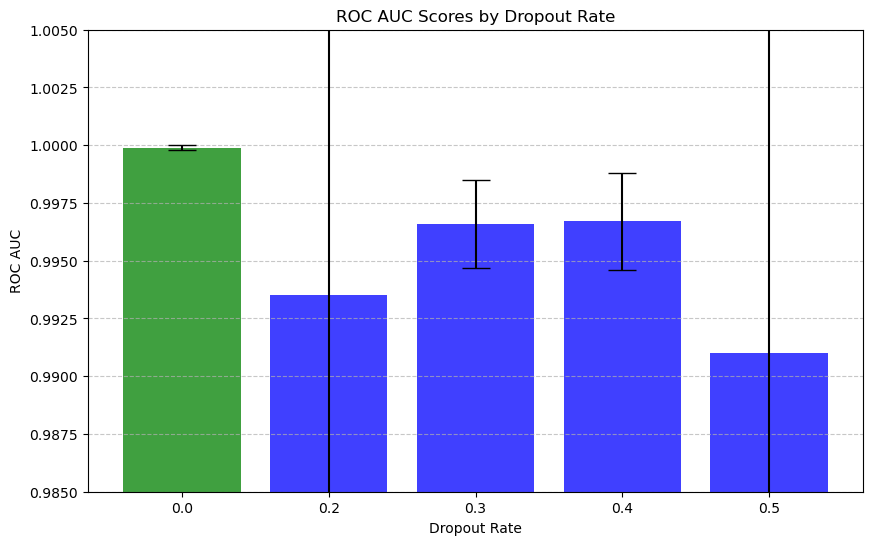

In [24]:
# make bar plot with error bars
plt.figure(figsize=(10, 6))

# create colors list: first green blue, rest blue
colors = ["green"] + ["blue"] * (len(roc_auc_scores_dropout) - 1)

plt.bar(
    roc_auc_scores_dropout["dropout_rate"].astype(str),
    roc_auc_scores_dropout["roc_auc"],
    yerr=roc_auc_scores_dropout["std"],
    capsize=10,
    color=colors,
    alpha=0.75
)

# customize plot
plt.title("ROC AUC Scores by Dropout Rate")
plt.xlabel("Dropout Rate")
plt.ylabel("ROC AUC")

# adjust y-axis to better show the differences
plt.ylim(0.985, 1.005)

# add horizontal grid lines for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

The previous best model's performance from tuning the learning rate is
included here.
It is still plotted in green.
The new results from tuning the dropout rate are plotted in blue.

Again, there is one case in which the mean and the standard deviation add up to
a value slightly larger than one, but that's not too much of an issue, because
it happened because of averaging across the batches.
Also, the different model's performance is very similar across all dropout rates.

However, none of the model's performance matches the ResNet18 baseline performance
without any dropout.

Based on this, the optimal dropout rate for this setting is 0.0, and no dropout
will be used here.

### Modify Model Architecture

The final thing to tune about the network is experimenting with
modifications in architecture.
ResNet18 is already an optimized architecture, and works quite well for image
classification out of the box.
It is not recommended to make drastic changes to the architecture, as that could
destroy valuable pre-trained features.
Nonetheless, certain modifications are rather safe.

To be exact, I already modified the network's architecture in this notebook.
To enable fine-tuning, I had to adapt the original fully connected layer
(`model.fc`) that maps 512 features to 1000 classes to another one mapping the
same 512 features to just two classes (muffins and chihuahuas).
Also, doppout was introduced by replacing the original single linear layer with
a sequential module containing a dropout layer followed by a linear layer.
While these are minimal modifications, they still technically are architectural
changes to the model's architecture.

Here, however, I will experiment with slightly more complex modifications, even
though they will also not be too drastic.
I will limit myself to replacing the original fully connected layer with a more
complex sequential structure.
Two to three layer should be sufficient for this purpose, especially because
the model's performance is already very good regarding ROC AUC without this.
I will not modify the existing ResNet blocks, because that could potentially
cause the model to forget pre-trained features, as described before.

Learning rate for new layers should be 10x higher than for pretrained layers.
Optimum learning rate for hidden layers so far has been 0.001.
It will be kept like that.
The new layers will be trained with a learning rate of 0.01.

In [25]:
class ResNet18_Extended(nn.Module):
    def __init__(self, architecture="simple"):
        super(ResNet18_Extended, self).__init__()
        self.model = models.resnet18(weights="IMAGENET1K_V1")
        
        # freeze pre-trained layers
        for param in self.model.parameters():
            param.requires_grad = False
            
        # get number of features
        num_features = self.model.fc.in_features
        
        # modify final layers (these will be trainable by default)
        if architecture == "simple":
            self.model.fc = nn.Sequential(
                nn.Linear(num_features, 256),
                nn.ReLU(),
                nn.BatchNorm1d(256),
                nn.Linear(256, 2)
            )
        elif architecture == "medium":
            self.model.fc = nn.Sequential(
                nn.Linear(num_features, 256),
                nn.ReLU(),
                nn.BatchNorm1d(256),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.BatchNorm1d(128),
                nn.Linear(128, 2)
            )
        elif architecture == "wide":
            self.model.fc = nn.Sequential(
                nn.Linear(num_features, 384),
                nn.ReLU(),
                nn.BatchNorm1d(384),
                nn.Linear(384, 2)
            )

    def forward(self, x):
        return self.model(x)
    
    def get_param_groups(self, base_lr=0.001):
        """Return parameter groups with different learning rates."""
        # parameters of pretrained layers get base_lr
        # parameters of new layers (fc) get 10x base_lr
        pretrained_params = []
        new_params = []
        
        for name, param in self.named_parameters():
            if "fc" in name:  # new layers
                new_params.append(param)
            else:  # pretrained layers
                pretrained_params.append(param)
        
        return [
            {'params': pretrained_params, 'lr': base_lr},
            {'params': new_params, 'lr': base_lr * 10}
        ]

In [26]:
def train_extended_model(architecture="simple", base_lr=0.001, n_epochs=50):
    """Train extended model with specified architecture."""
    
    # initialize model and move to device
    model = ResNet18_Extended(architecture=architecture).to(device)
    
    # get parameter groups with different learning rates
    param_groups = model.get_param_groups(base_lr=base_lr)
    
    # initialize optimizer and criterion
    optimizer = optim.Adam(param_groups)
    criterion = nn.CrossEntropyLoss()
    
    # initialize early stopping
    early_stopping = EarlyStopping(
        patience=7,
        min_delta=0.001,
        path=PATH_MODELS / f"model_checkpoint_extended_{architecture}.pt"
    )
    
    # initialize history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_metrics': []
    }
    
    # training loop
    for epoch in range(n_epochs):
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, device
        )
        
        val_metrics = validate(model, val_loader, criterion, device)
        
        # store history and print progress
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_metrics'].append(val_metrics)
        
        print(f"Epoch {epoch+1}/{n_epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_metrics['val_loss']:.4f}, Val Acc: {val_metrics['val_acc']:.2f}%")
        print("-" * 50)
        
        # early stopping check
        early_stopping(val_metrics["val_loss"], model)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            model.load_state_dict(early_stopping.best_model)
            break
    
    return model, history

In [27]:
# train models with different architectures
architectures = ["simple", "medium", "wide"]
results_architecture = {}

for arch in architectures:
    print(f"\nTraining with extended architecture: {arch}")
    print("-" * 50)
    _, history = train_extended_model(architecture=arch)
    results_architecture[arch] = evaluate_model(
        f"ResNet18_extended_{arch}",
        history["val_metrics"]
    )


Training with extended architecture: simple
--------------------------------------------------
Epoch 1/50:
Train Loss: 0.0708, Train Acc: 97.30%
Val Loss: 0.0573, Val Acc: 98.31%
--------------------------------------------------
Epoch 2/50:
Train Loss: 0.0372, Train Acc: 98.71%
Val Loss: 0.0106, Val Acc: 99.58%
--------------------------------------------------
Epoch 3/50:
Train Loss: 0.0255, Train Acc: 99.10%
Val Loss: 0.0187, Val Acc: 99.15%
--------------------------------------------------
Epoch 4/50:
Train Loss: 0.0314, Train Acc: 98.94%
Val Loss: 0.0168, Val Acc: 99.58%
--------------------------------------------------
Epoch 5/50:
Train Loss: 0.0285, Train Acc: 99.10%
Val Loss: 0.0175, Val Acc: 99.37%
--------------------------------------------------
Epoch 6/50:
Train Loss: 0.0227, Train Acc: 99.13%
Val Loss: 0.0108, Val Acc: 99.47%
--------------------------------------------------
Epoch 7/50:
Train Loss: 0.0342, Train Acc: 98.86%
Val Loss: 0.0112, Val Acc: 99.47%
----------

#### Model Selection

In [28]:
# collect roc auc scores across all extended architectures
roc_auc_scores_architecture = pd.DataFrame([
    {
        "architecture": arch,
        "roc_auc": float(results_architecture[arch]["val_roc_auc"].split(" ± ")[0]),
        "std": float(results_architecture[arch]["val_roc_auc"].split(" ± ")[1])
    }
    for arch in results_architecture
])

roc_auc_scores_architecture

,architecture,roc_auc,std
0,simple,0.9999,0.0003
1,medium,0.9997,0.0007
2,wide,0.9995,0.0009


In [29]:
# add the previous best performing model
roc_auc_scores_architecture = pd.concat(
    [
        roc_auc_scores_lr[roc_auc_scores_lr["learning_rate"] == 0.001][["roc_auc", "std"]],
        roc_auc_scores_architecture,
    ]
).reset_index(drop=True)

roc_auc_scores_architecture.loc[0, "architecture"] = "baseline"

roc_auc_scores_architecture

,roc_auc,std,architecture
0,0.9999,0.0001,baseline
1,0.9999,0.0003,simple
2,0.9997,0.0007,medium
3,0.9995,0.0009,wide


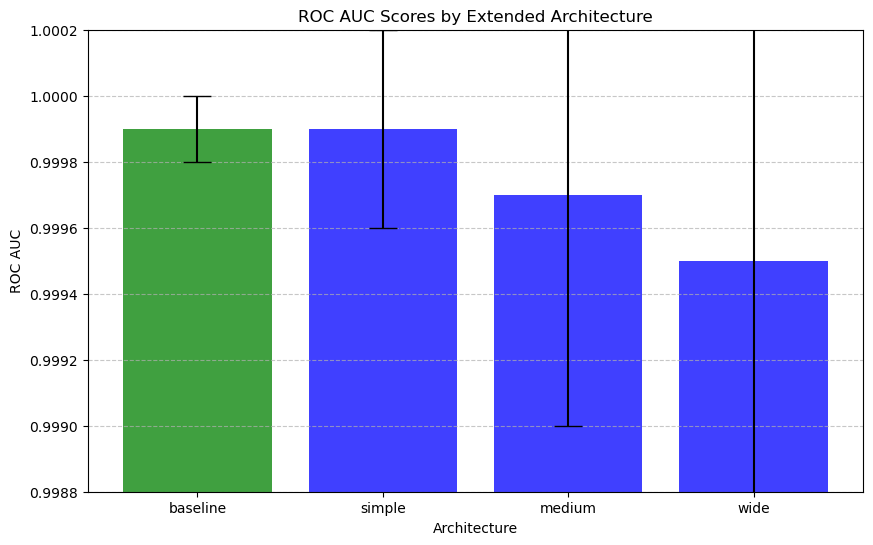

In [30]:
# make bar plot with error bars
plt.figure(figsize=(10, 6))

# create colors list: first green blue, rest blue
colors = ["green"] + ["blue"] * (len(roc_auc_scores_architecture) - 1)

plt.bar(
    roc_auc_scores_architecture["architecture"].astype(str),
    roc_auc_scores_architecture["roc_auc"],
    yerr=roc_auc_scores_architecture["std"],
    capsize=10,
    color=colors,
    alpha=0.75
)

# customize plot
plt.title("ROC AUC Scores by Extended Architecture")
plt.xlabel("Architecture")
plt.ylabel("ROC AUC")

# adjust y-axis to better show the differences
plt.ylim(0.9988, 1.0002)

# add horizontal grid lines for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

Once again the issue with the mathematical impossibility,
and again, all models show near optimal performance.
But the baseline model and the simple architecture perform best and equally
well.
The changes in architecture did not improve the model's performance,
so the baseline model will be used as the selected model.


## Final Validation

Based on the previous tests, the baseline model was selected.
Or rather a ResNet18 model with default hyper parameters:

- learning rate: 0.001
- dropout rate: 0.0
- architecture: one fully connected layer with two output neurons

Now, I will evaluate the baseline model on unseen data using the test set to
get a final performance metric.
This provides an unbiased estimate of real-world.
To get a more comprehensive assessment, the performance on the test set will be
compared to the performance on the validation set during training.

In [31]:
# set the model to evaluation mode
model_baseline.eval()

# evaluate model on test set
test_metrics = validate(
    model_baseline,
    val_loader=test_loader,
    criterion=criterion,
    device=device
)

In [32]:
# create dataframe with test metrics and validation metrics
df_metrics = pd.DataFrame([
    {
        "loss": test_metrics["val_loss"],
        "loss_std": None,  # no std for test metrics
        "acc": test_metrics["val_acc"],
        "acc_std": None,
        "roc_auc": test_metrics["val_roc_auc"],
        "roc_auc_std": None,
        "f1": test_metrics["val_f1"],
        "f1_std": None
    },
    {
        "loss": float(metrics_val_baseline["val_loss"].split(" ± ")[0]),
        "loss_std": float(metrics_val_baseline["val_loss"].split(" ± ")[1]),
        "acc": float(metrics_val_baseline["val_acc"].split(" ± ")[0].strip("%")),
        "acc_std": float(metrics_val_baseline["val_acc"].split(" ± ")[1].strip("%")),
        "roc_auc": float(metrics_val_baseline["val_roc_auc"].split(" ± ")[0]),
        "roc_auc_std": float(metrics_val_baseline["val_roc_auc"].split(" ± ")[1]),
        "f1": float(metrics_val_baseline["val_f1"].split(" ± ")[0]),
        "f1_std": float(metrics_val_baseline["val_f1"].split(" ± ")[1])
    }
], index=["test", "validation"])

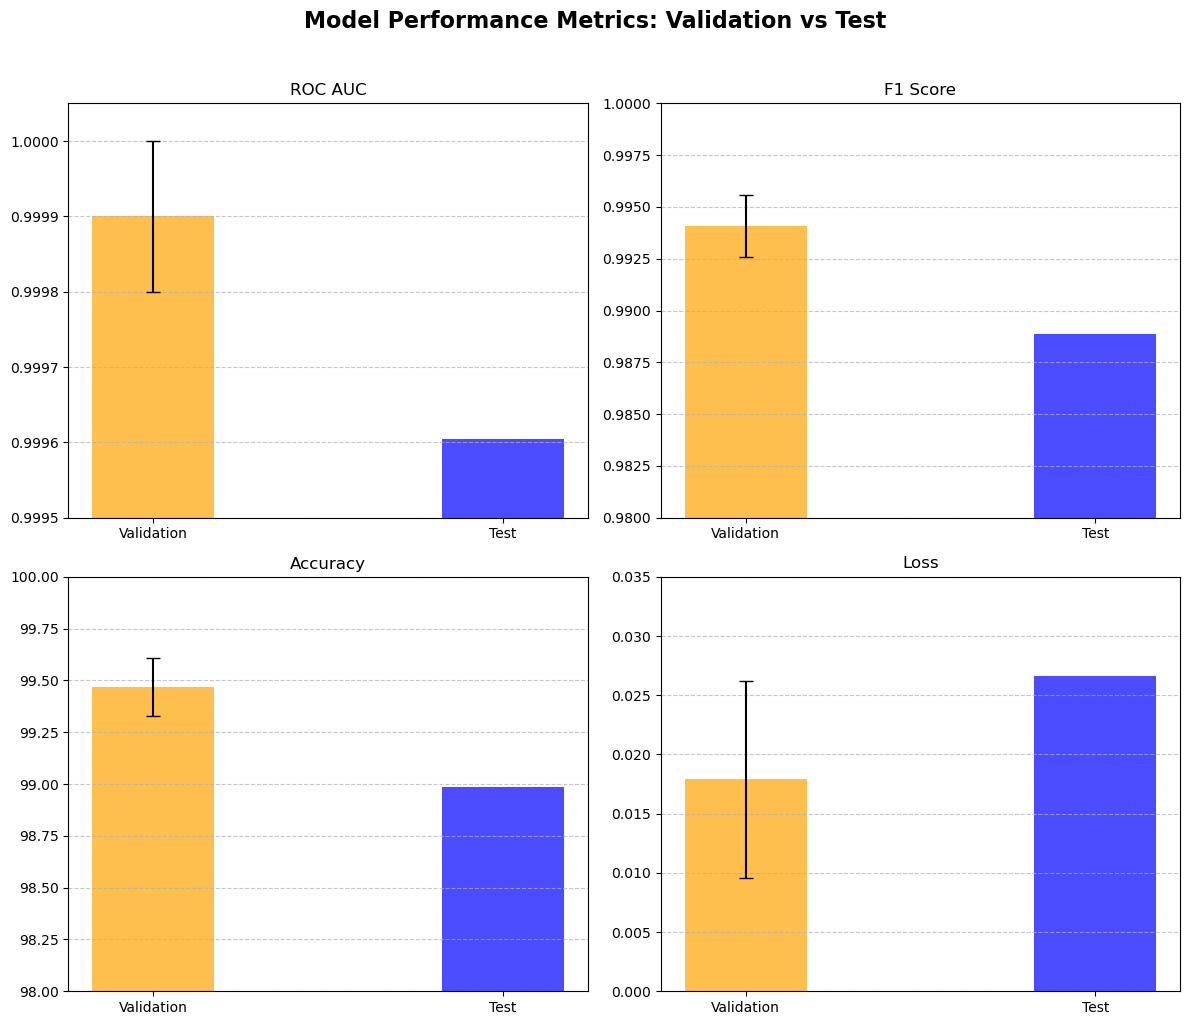

,loss,loss_std,acc,acc_std,roc_auc,roc_auc_std,f1,f1_std
test,0.026605,NaN,98.984772,NaN,0.999605,NaN,0.988889,NaN
validation,0.017900,0.0083,99.470000,0.14,0.999900,0.0001,0.994100,0.0015


In [33]:
# create 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
metrics = ["roc_auc", "f1", "acc", "loss"]
titles = ["ROC AUC", "F1 Score", "Accuracy", "Loss"]

# define y-axis limits for each metric
y_limits = {
    "roc_auc": (0.9995, 1.00005),
    "f1": (0.98, 1),
    "acc": (98.0, 100),
    "loss": (0, 0.035)
}

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]
    
    # plot bars
    ax.bar(
        0,  # validation position
        df_metrics.loc["validation", metric],
        width=0.35,
        yerr=df_metrics.loc["validation", f"{metric}_std"],
        label="Validation",
        color="orange",
        alpha=0.7,
        capsize=5
    )
    ax.bar(
        1,  # test position
        df_metrics.loc["test", metric],
        width=0.35,
        label="Test",
        color="blue",
        alpha=0.7
    )
    
    # customize subplot
    ax.set_title(title)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Validation", "Test"])
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    
    # set y-axis limits for this metric
    ax.set_ylim(y_limits[metric])

plt.suptitle(
    "Model Performance Metrics: Validation vs Test",
    y=1.02,
    fontsize=16,
    fontweight="bold"
)
plt.tight_layout()
plt.show()

df_metrics

The model shows excellent performance across all metrics.
All metrics are close to their theoretical maximum values
It performs slightly better on the validation set,
but the differences are very small.
The model maintains high performance across different evaluation metrics
This demonstrates strong generalization capabilities without overfitting.

Finally, the baseline model was the best performing model.
It is the regular ResNet18 model with default hyper parameters.
Even though finally nothing changed, this way it was possible to demonstrate
that the default parameters well optimized already.

ResNet18 is the smallest and simplest version of ResNet.
It was pre-trained on image net, fine-tuned on a laptop with an
integrated Apple Silicon M3 GPU, and shows near perfect performance.
I think this finally settles the debate that machine learning is **not**
confused by muffins and chihuahuas.
No other more complex or larger architectures need to be tested here.

## Outlook

Here are some further ideas for how it would be possible to go on:

- it would be interesting to look at some of the cases in which it fails
- the original meme (4x4 panel) should be cut into separate images,
which then should be used to query the model
- adding data augmentation such as geometric transformations or color space
modifications
- more sophisticated hyper parameter tuning techniques like Bayesian
optimization or population-based training
- experimenting with different optimizers and, activation functions and
regularization like weight decay, label smoothing or gradient clipping